# Ingeniería de atributos y selección de variables
---

In [34]:
# Llibrerías a utilizar
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [35]:
# Importamos el dataset
vgamesales_url = 'https://raw.githubusercontent.com/jbeltrang/datasets-ch/main/Video_Games_Sales_as_at_22_Dec_2016.csv'
vgamesales = pd.read_csv(vgamesales_url)
vgamesales

# Hacemos un dataframe trabajable y limpiamos la data que sea mayor al 2016
vgamesales_df = vgamesales
vgamesales_df = vgamesales_df.loc[vgamesales_df['Year_of_Release'] <= 2016]
vgamesales_df = vgamesales_df.dropna(subset=['Year_of_Release'])

### Dataset

---

#### Descripción del Dataset
Este dataset incluye datos de más de 100.000 videojuegos de distintas plataformas desde 1980 hasta 2016. Dentro de la data que contiene está la plataforma, año de lanzamiento, ventas totales, puntaje de crítica, desarrollado, rating, entre otros.

*Fuente:*

[Kaggle: Video Game Sales with Ratings](https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings)

#### Descripción de Variables
| Columna | Descripción |
| --- | --- |
| Rank | Ranking de las ventas promedio |
| Name | Nombre del videojuego |
| Platform | Plataforma de lanzamiento del videojuego (PC, PS4, etc.) |
| Year | Año de lanzamiento del videojuego |
| Genre | Género del videojuego |
| Publisher | Editor del videojuego |
| NA_Sales | Ventas en Norteamérica (en millones) |
| EU_Sales | Ventas en Europa (en millones) |
| JP_Sales | Ventas en Japón (en millones) |
| Other_Sales | Ventas en el resto del mundo (en millones) |
| Global_Sales | Ventas totales a nivel mundial. |
| Critic_score | Puntaje agregado del staff de Metacritic |
| Criticcount | Número de críticas usadas para obtener el puntaje del staff |
| User_score | Puntaje asignado por los suscriptores de Metacritic |
| Usercount | Número de usuarios que dieron puntaje de crítica |
| Developer | Desarrollador |
| Rating | Rating asignado por la ESRB |

In [36]:
# Tipos de variables
vgamesales_df_types = vgamesales_df.dtypes
print("Tipos de variables:\n")
print(vgamesales_df_types)

## Identificación de cantidad de NaN por columna
nan_count = vgamesales_df.isna().sum()
print("\nNaN por columna:\n")
print(nan_count)

# Análisis Estadístico de variables numéricas

## Seleccionamos solo las columnas numéricas
vgamesales_numeric_df = vgamesales_df.select_dtypes(include=[np.number])

## Cálculo de la media por columna
mean = vgamesales_numeric_df.mean()
print("\nMedia:\n")
print(mean)

## Cálculo de la mediana por columna
median = vgamesales_numeric_df.median()
print("\nMediana:\n")
print(median)

## Cálculo de la desviación estándar por columna
standard_deviation = vgamesales_numeric_df.std()
print("\nDesviación estándar:\n")
print(standard_deviation)

## Cálculo de la varianza por columna
variance = vgamesales_numeric_df.var()
print("\nVarianza:\n")
print(variance)

## Cálculo de otros estadísticos relevantes
print("\nMínimo:\n")
print(vgamesales_numeric_df.min())

print("\nMáximo:\n")
print(vgamesales_numeric_df.max())

print("\nQuantiles:\n")
print(vgamesales_numeric_df.quantile([0.25, 0.5, 0.75]))

Tipos de variables:

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

NaN por columna:

Name                  2
Platform              0
Year_of_Release       0
Genre                 2
Publisher            32
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8463
Critic_Count       8463
User_Score         6607
User_Count         8983
Developer          6540
Rating             6678
dtype: int64

Media:

Year_of_Release    2006.484616
NA_Sales              0.264089
EU_Sales              0.145945
JP_Sales       

## Selección de Variables y Encoding

In [37]:
# Definimos un subset para trabajar la selección de variables

vgamesales_set = vgamesales
# Drop de valores nulos y limpieza
vgamesales_set = vgamesales_set.dropna(subset=['Year_of_Release','Genre',"Critic_Score","User_Score"])
vgamesales_set = vgamesales_set.loc[vgamesales_set['User_Score'] != "tbd"]
# Conversión de fechas
vgamesales_set['Year_of_Release'] = pd.to_datetime(vgamesales_set['Year_of_Release'], format="%Y")
vgamesales_set['Year'] = vgamesales_set['Year_of_Release'].dt.year
# Obtener la columna de años
years = vgamesales_set['Year']
# Calcular las décadas correspondientes
decades = (years // 10) * 10
# Subset
vgamesales_set = vgamesales_set[["Platform","Year","Genre","Global_Sales","Critic_Score","User_Score"]]
# One-hot Encoding
vgamesales_set = pd.get_dummies(vgamesales_set, columns=["Platform","Genre"])
decades_encoded = pd.get_dummies(decades, prefix='Decade')
# Concatenar las columnas de décadas con el dataset original
vgamesales_set_encoded = pd.concat([vgamesales_set, decades_encoded], axis=1)
# Eliminar la columna original de "Year"
vgamesales_set_encoded.drop('Year', axis=1, inplace=True)
vgamesales_set = vgamesales_set_encoded

# Normalización de los Scores
Critic_Score_normalizado = StandardScaler().fit_transform(vgamesales_set['Critic_Score'].values.reshape(-1, 1))
vgamesales_set['Critic_Score'] = Critic_Score_normalizado
User_Score_normalizado = StandardScaler().fit_transform(vgamesales_set['User_Score'].values.reshape(-1, 1))
vgamesales_set['User_Score'] = User_Score_normalizado

vgamesales_set

,Global_Sales,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Decade_1980,Decade_1990,Decade_2000,Decade_2010
0,82.53,0.414248,0.566522,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,35.52,0.847146,0.774898,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,32.77,0.702847,0.566522,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6,29.80,1.352194,0.913816,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,28.92,-0.884446,-0.405902,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16677,0.01,0.774997,1.122193,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
16696,0.01,0.702847,0.288686,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
16700,0.01,-0.667997,-0.961573,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
16706,0.01,-0.740146,0.010851,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


Luego de haber hecho el set a trabajar, ajustamos la variable Global_sales para generar un modelo de clasificación. Para eso haremos un barplot que nos permita observar la variable y como esta se acumula.

<Axes: >

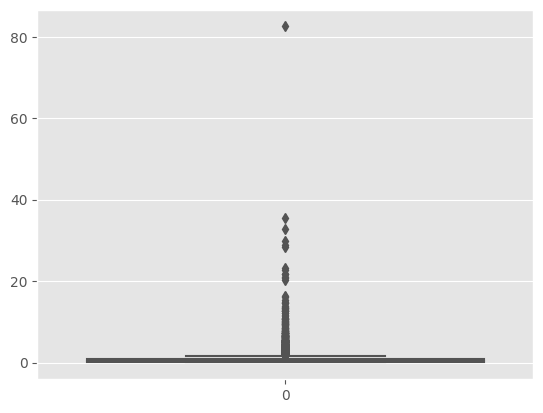

In [38]:
sns.boxplot(data=vgamesales_set["Global_Sales"])

En base a lo anterior, definimos una variable categórica que tomará el valor 1 cuando Global_Sales sea mayor a la media y 0 de lo contrario.

In [39]:
# Calcular el promedio de las ventas globales
global_sales_mean = vgamesales_set['Global_Sales'].mean()

# Crear una nueva columna llamada "Sales_Category" y asignar 1 si "Global_Sales" es mayor que el promedio, y 0 en caso contrario
vgamesales_set['Sales_Category'] = np.where(vgamesales_set['Global_Sales'] > global_sales_mean, 1, 0)
vgamesales_set.drop('Global_Sales', axis=1, inplace=True)

## Análisis de Correlación

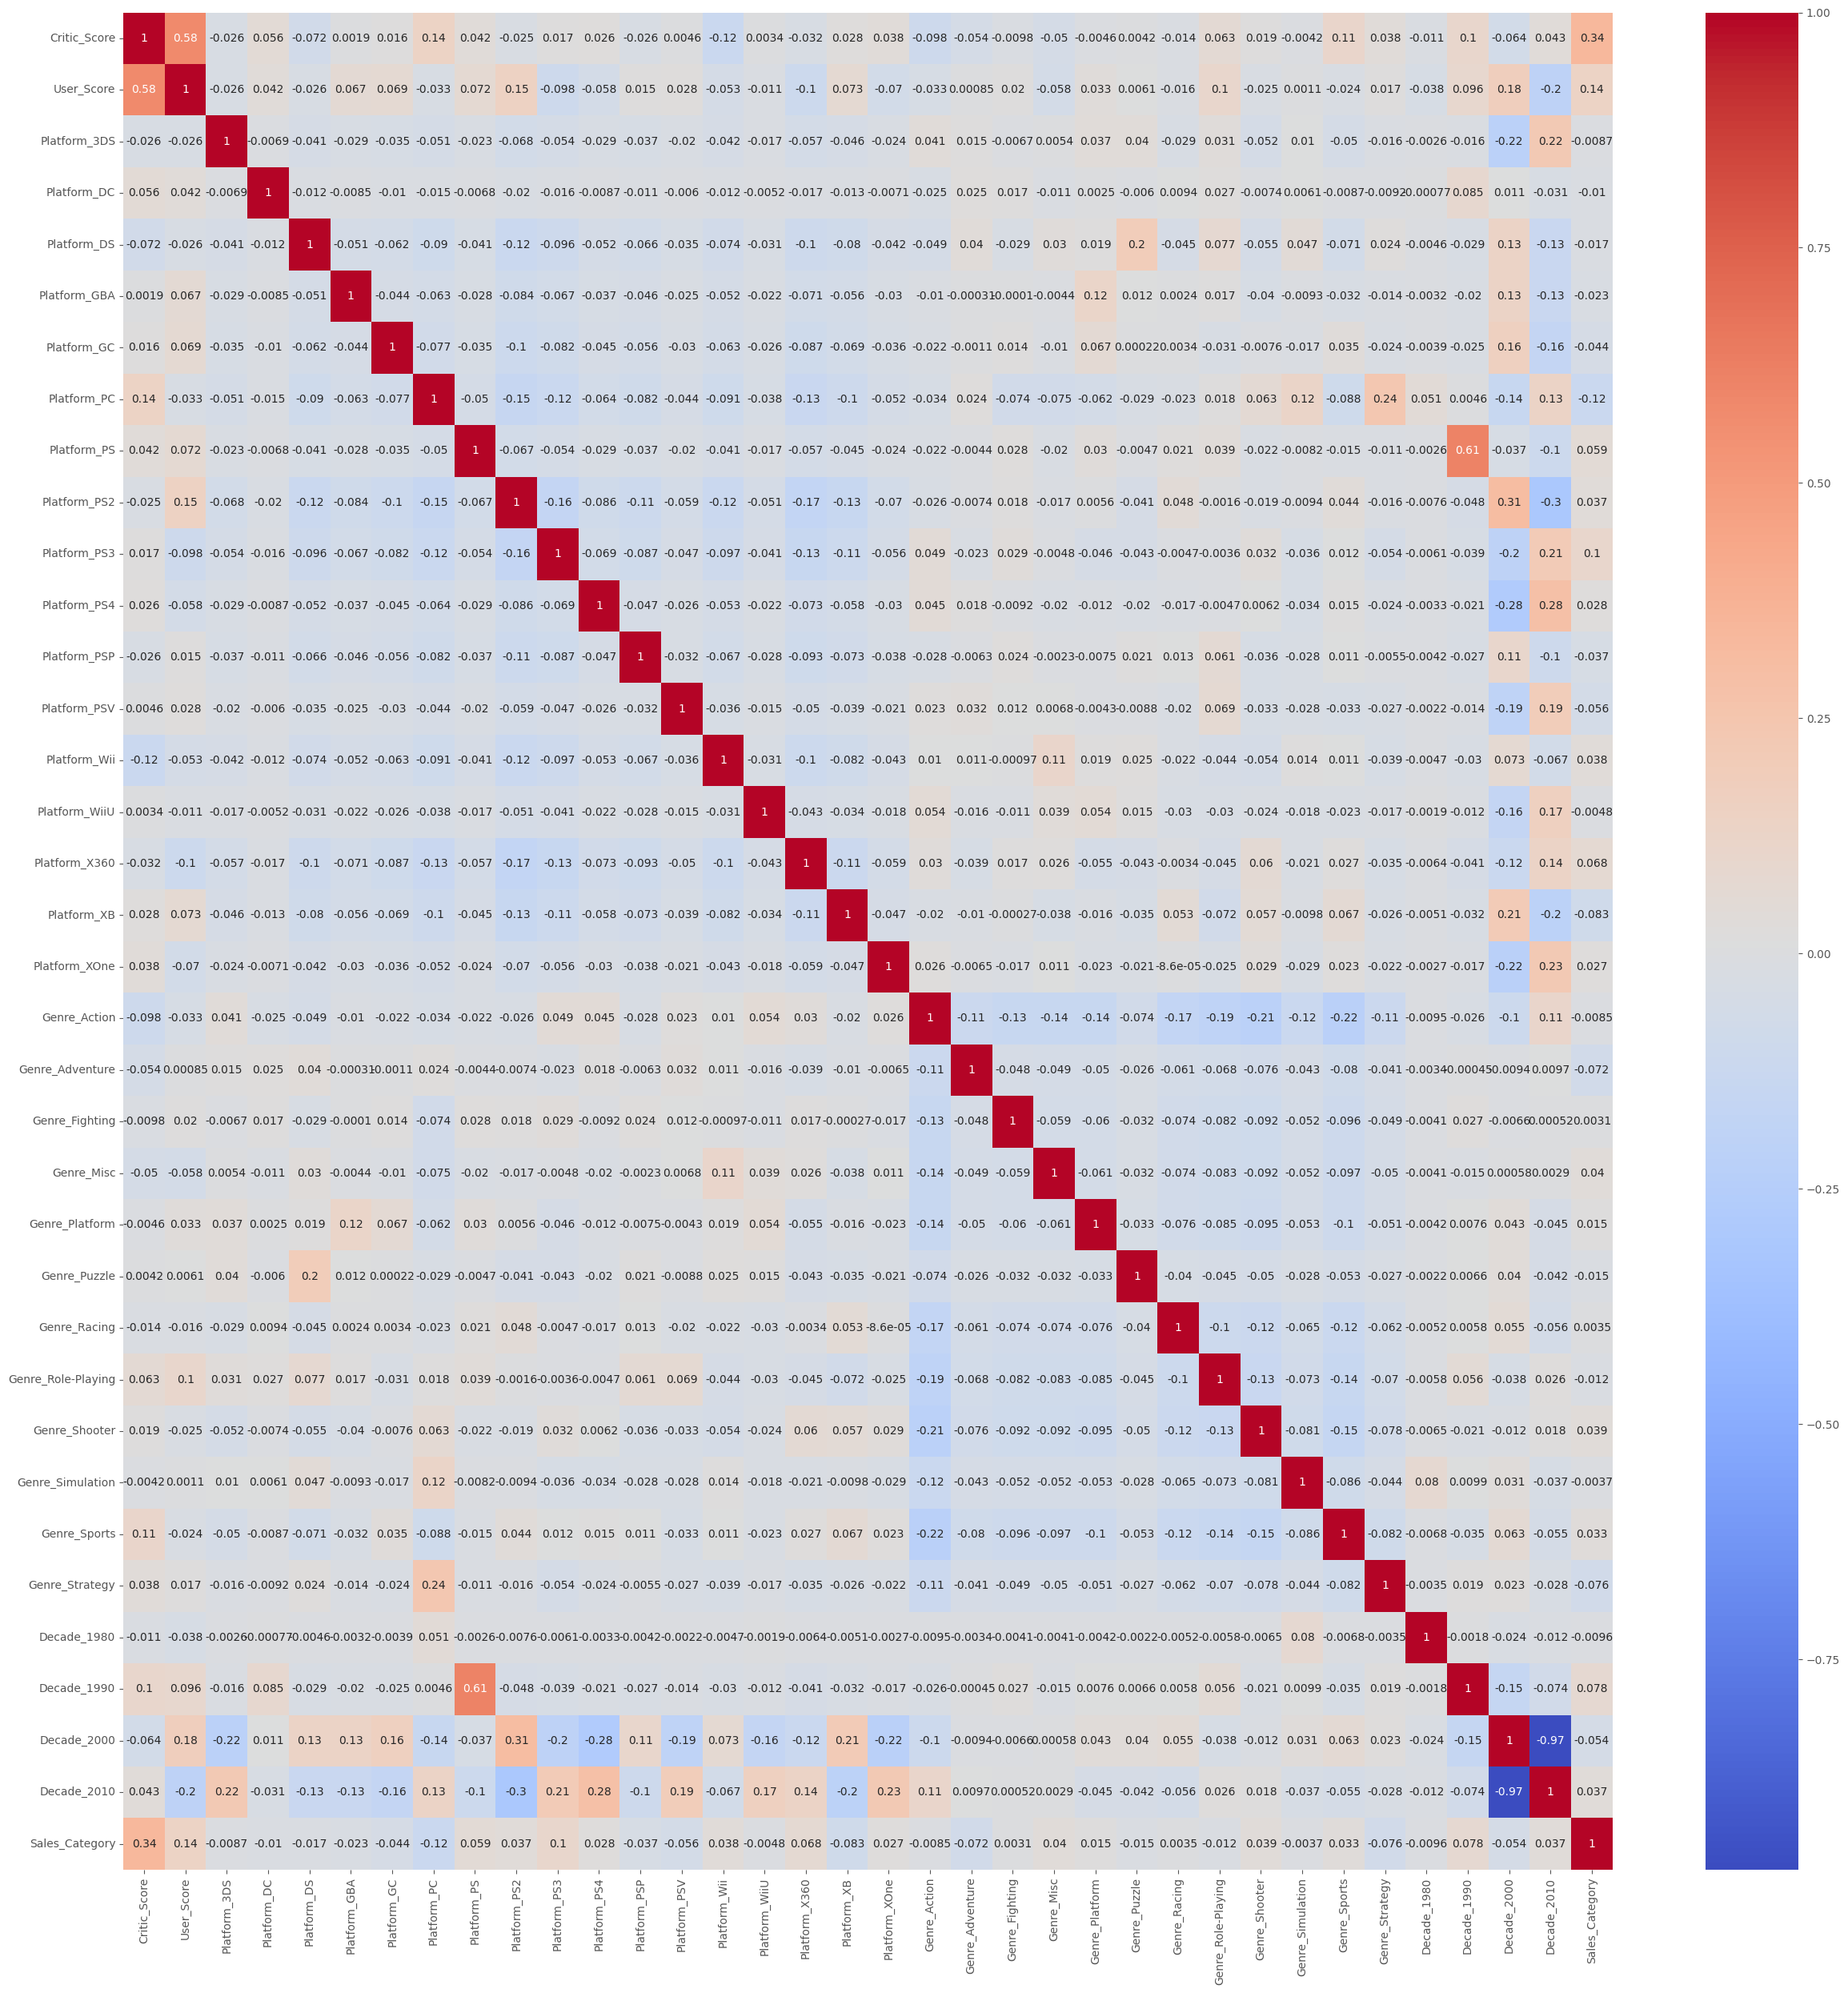

In [40]:
# Crear la matriz de correlación
correlation_matrix = vgamesales_set.corr()

# Configurar el heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el Heatmap
plt.show()

## Clustering y PCA

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


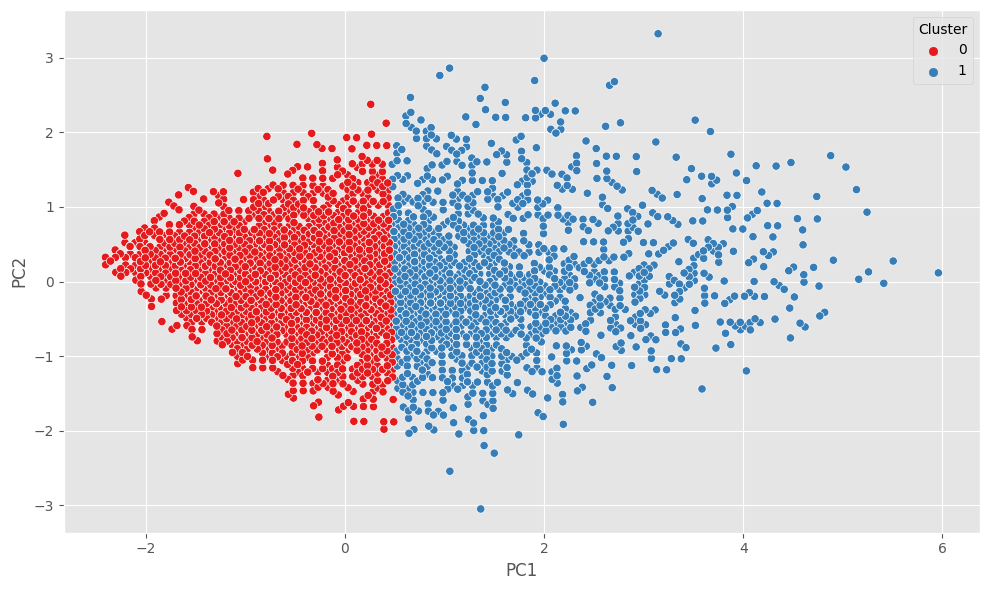

Coeficiente de Silhouette: 0.4853228299182663


In [41]:
# Seleccionar las columnas relevantes para el clustering
clustering_data = vgamesales_set[['Critic_Score', 'User_Score']]

# Crear una instancia del modelo K-means con el número deseado de clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Entrenar el modelo de K-means
kmeans.fit(clustering_data)

# Obtener las etiquetas de cluster asignadas a cada instancia
cluster_labels = kmeans.labels_

# Realizar el PCA en los datos de clustering
pca_result = pca.fit_transform(clustering_data)

# Crear un nuevo dataframe con los resultados del PCA y las etiquetas de cluster
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Configurar el scatter plot con los puntos agrupados por color según el cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1')

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el scatter plot
plt.show()

# Calcular el coeficiente de Silhouette
silhouette_avg = silhouette_score(clustering_data, cluster_labels)

# Imprimir el coeficiente de Silhouette
print("Coeficiente de Silhouette:", silhouette_avg)


## Interpretación

Una vez realizado el Principal Component Analysis luego de haber hecho clustering con un n = 2, vemos que existen 2 grupos que a simple vista no están bien definidos. Una de las razones de esto es que las variables utilizadas tenían una correlación de 0.58. Lo cual, dejaba la opción de dejar una de las 2 variables o hacer el trabajo de clustering. La segunda opción arrojó los resultados que podemos ver en el gráfico.

Evaluando los resultados mediante el coeficiente de Silhouette, vemos que se obtuvo un coeficiente de aproximadamente 0.49, lo cual podríamos considerar como moderadamente aceptable, considerando que los resultados varían entre -1 y 1.

A modo de conclusión, se incorporará este clustering en el modelo de clasificación.


## Modelamiento

In [42]:
# Incorporación del los Clusters
vgamesales_set['Cluster_Labels'] = cluster_labels

X = vgamesales_set.drop('Sales_Category', axis=1)
y = vgamesales_set['Sales_Category']

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de Regresión Logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión:", precision)

# Calcular la exhaustividad (recall)
recall = recall_score(y_test, y_pred)
print("Exhaustividad (Recall):", recall)

# Calcular la puntuación F1
f1 = f1_score(y_test, y_pred)
print("Puntuación F1:", f1)

# Calcular la exactitud (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud (Accuracy):", accuracy)

Precisión: 0.7653061224489796
Exhaustividad (Recall): 0.4178272980501393
Puntuación F1: 0.5405405405405406
Exactitud (Accuracy): 0.8150833937635968


## Interpretación

**Precisión**

La precisión obtenida es de aproximadamente 0.76, lo que significa que alrededor del 76% de las instancias clasificadas como positivas fueron clasificadas correctamente. Comparado con el 72% que arrojaba el modelo sin clustering, observamos una mejora relativa de la precisión.

**Recall**

El Recall obtenido es de aproximadamente 0.41, lo que significa que alrededor del 41% de las instancias positivas fueron identificadas correctamente por el modelo. Esto se mantiene de manera casi invariable con o sin clustering.

**Puntuación F1**

La puntuación F1 obtenida es de aproximadamente 0.53, lo que indica un equilibrio razonable entre la precisión y el recall. Se oberva una mejora de 1 punto porcentual al realizar clustering.

**Accuracy**

El accuracy obtenido es de aproximadamente 0.81, lo que significa que alrededor del 81% de las instancias fueron clasificadas correctamente por el modelo. Esto se mantiene de manera casi invariable con o sin clustering..

En resumen, los resultados indican que el modelo tiene una precisión y accuracy decentes, lo que significa que es capaz de clasificar correctamente la mayoría de las instancias. Sin embargo, el recall es relativamente bajo, lo que indica que el modelo puede perder algunas instancias positivas. La puntuación F1 muestra un equilibrio razonable entre la precisión y el recall. Considerando que ninguna de las métricas bajó al incorporar los clusters, se justifica el haber hecho esa agrupación, lo cual no significa que se pueda descartar sobreajuste observando solamente estas métricas.

## Validación Cruzada

In [44]:
# Realizar validación cruzada con 35 folds
scores = cross_val_score(model, X, y, cv=30)

# Mostrar los resultados
print("Puntajes de validación cruzada:", scores)
print("Puntaje promedio:", scores.mean())

Puntajes de validación cruzada: [0.79565217 0.83478261 0.80434783 0.82608696 0.8        0.8173913
 0.81304348 0.79565217 0.76956522 0.79130435 0.8        0.8
 0.81304348 0.77826087 0.82173913 0.83478261 0.85652174 0.8
 0.7826087  0.79565217 0.80869565 0.80434783 0.77826087 0.8173913
 0.82532751 0.79475983 0.80786026 0.82532751 0.81222707 0.80786026]
Puntaje promedio: 0.8070830960065819


## Interpretación

El puntaje promedio de validación cruzada es 0.81 aproximadamente, lo que indica que en promedio el modelo tiene un rendimiento aceptable. Sin embargo, es importante considerar que este puntaje es específico para los datos y modelo utilizados en la validación cruzada. En este caso, la variabilidad de los puntajes obtenidos es baja, por lo que se puede seguir sosteniendo que el modelo tiene un buen rendimiento.

## Comparación de Modelos

In [48]:
# Variable para calcular MSE y métricas adicionales
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return mse, precision, recall, f1, accuracy

# Variable para almacenar los modelos
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    # Agrega aquí más modelos que desees probar
]

# Iteramos sobre los modelos
for name, model in models:
    # Calculamos las métricas utilizando cross_val_predict
    y_pred = cross_val_predict(model, X, y, cv=30)
    mse, precision, recall, f1, accuracy = calculate_metrics(y, y_pred)

    print(f"Modelo: {name}")
    print(f"Precisión: {precision}")
    print(f"Recall: {recall}")
    print(f"Puntuación F1: {f1}")
    print(f"Accuracy: {accuracy}")
    print("------")

Modelo: Logistic Regression
Precisión: 0.6741344195519349
Recall: 0.39593301435406697
Puntuación F1: 0.4988696307460436
Accuracy: 0.807078619089063
------
Modelo: Decision Tree
Precisión: 0.4596018735362998
Recall: 0.4694976076555024
Puntuación F1: 0.4644970414201184
Accuracy: 0.7374528575572962
------
Modelo: Random Forest
Precisión: 0.577922077922078
Recall: 0.4258373205741627
Puntuación F1: 0.49035812672176315
Accuracy: 0.7853205686103858
------


## Interpretación

**Precisión**: El modelo de Regresión Logística tiene la precisión más alta. Esto indica que este modelo logró predecir mayores predicciones correctas positivas sobre el total de predicciones positivas.

**Recall**: El modelo Decision Tree tiene el recall más alto, lo cual significa que este modelo logró la mayor cantidad de muestras positivas correctamente predichas sobre el total de los valores predichos.

**Puntuación F1**: El modelo de Regresión Logística tiene la puntuación F1 más alta.

**Accuracy**: El modelo de Regresión Logística tiene la accuracy más alta. Lo que significa que logró una mayor cantidad de predicciones correctas por sobre el total.

Considerando estos resultados y el foco del proyecto que es poder predecir si se tendrán ventas por sobre el promedio o no, el modelo a elegir sería el de Regresión Logística, dado que tiene un accuracy mucho mayor que el resto de los modelos. Dicho indicador es considerablemente el más importante de los analizados a la hora de discriminar modelos.